In [28]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Load Dataset

In [4]:
train_black_path = "C:/Users/srisa/OneDrive - Hochschule Luzern/Masters/PG 4th Sem/Computer Vision/archive/data/train_black"
train_color_path = "C:/Users/srisa/OneDrive - Hochschule Luzern/Masters/PG 4th Sem/Computer Vision/archive/data/train_color"
test_black_path = "C:/Users/srisa/OneDrive - Hochschule Luzern/Masters/PG 4th Sem/Computer Vision/archive/data/test_black"
test_color_path = "C:/Users/srisa/OneDrive - Hochschule Luzern/Masters/PG 4th Sem/Computer Vision/archive/data/test_color"

# Image Processing 

In [8]:
img_size = 120

# Lists to hold the training data
x_train = []
y_train = []
x_test = []
y_test = []

# Loading training images and preprocess them

In [11]:
for img_file in os.listdir(train_black_path):
    if img_file.endswith('.jpg') or img_file.endswith('.png'):
        # Load black and white image
        bw_image = Image.open(os.path.join(train_black_path, img_file)).convert('L').resize((img_size, img_size))
        bw_image_array = np.asarray(bw_image)

        # Check if the image shape is correct
        if bw_image_array.shape != (img_size, img_size):
            print(f"Warning: {img_file} has incorrect shape {bw_image_array.shape}. Skipping this image.")
            continue
        
        bw_image_array = bw_image_array.reshape((img_size, img_size, 1)) / 255.0  
        x_train.append(bw_image_array)

        # Load corresponding color image
        color_image = Image.open(os.path.join(train_color_path, img_file)).resize((img_size, img_size))
        color_image_array = np.asarray(color_image) / 255.0  
        y_train.append(color_image_array)

# Converting training lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Loading test images and preprocess them

In [20]:
for img_file in os.listdir(test_black_path):
    if img_file.endswith('.jpg') or img_file.endswith('.png'):
        # Load black and white test image
        bw_image = Image.open(os.path.join(test_black_path, img_file)).convert('L').resize((img_size, img_size))
        bw_image_array = np.asarray(bw_image)
        
        if bw_image_array.shape != (img_size, img_size):
            print(f"Warning: {img_file} has incorrect shape {bw_image_array.shape}. Skipping this image.")
            continue
        
        bw_image_array = bw_image_array.reshape((img_size, img_size, 1)) / 255.0
        x_test.append(bw_image_array)

        # Load corresponding color test image
        color_image = Image.open(os.path.join(test_color_path, img_file)).resize((img_size, img_size))
        color_image_array = np.asarray(color_image) / 255.0
        y_test.append(color_image_array)

# Convert test lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Checking shapes of training and test data

In [22]:

print("Training data shapes:")
print(f"x_train shape: {x_train.shape}")  
print(f"y_train shape: {y_train.shape}")  
print("Test data shapes:")
print(f"x_test shape: {x_test.shape}")    
print(f"y_test shape: {y_test.shape}")    

Training data shapes:
x_train shape: (5000, 120, 120, 1)
y_train shape: (5000, 120, 120, 3)
Test data shapes:
x_test shape: (739, 120, 120, 1)
y_test shape: (739, 120, 120, 3)


# Building the autoencoder model

In [24]:
def build_autoencoder():
    input_img = layers.Input(shape=(img_size, img_size, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

# Creating the model
autoencoder = build_autoencoder()

# Compiling the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Setting callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder_colorization_model.keras', 
                                    monitor='val_loss', 
                                    save_best_only=True, 
                                    verbose=1)

# Training the model
num_epochs = 50  
history = autoencoder.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

autoencoder.save('final_autoencoder_colorization_model.h5')

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 0.0388
Epoch 1: val_loss improved from inf to 0.01561, saving model to best_autoencoder_colorization_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 107s 581ms/step - loss: 0.0387 - val_loss: 0.0156
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 0.0158
Epoch 2: val_loss improved from 0.01561 to 0.01559, saving model to best_autoencoder_colorization_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 546ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 0.0145
Epoch 3: val_loss improved from 0.01559 to 0.01347, saving model to best_autoencoder_colorization_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 544ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 0.0135
Epoch 4: val_loss improved from 0.01347 to 0.01335, saving model to best_autoencoder_colorization_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 553ms/step - loss: 0

# Visualizing the result 

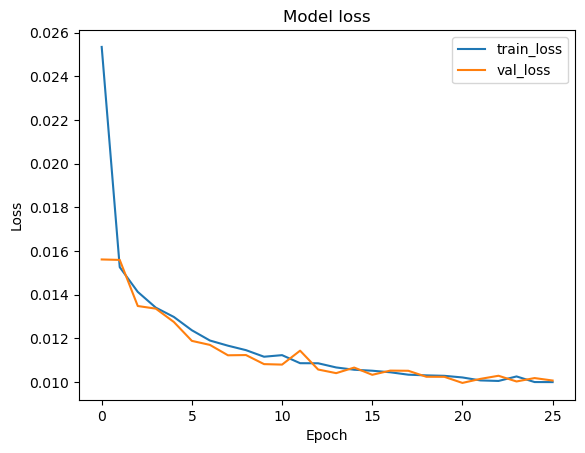

In [30]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Function to display original, predicted, and actual images

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step


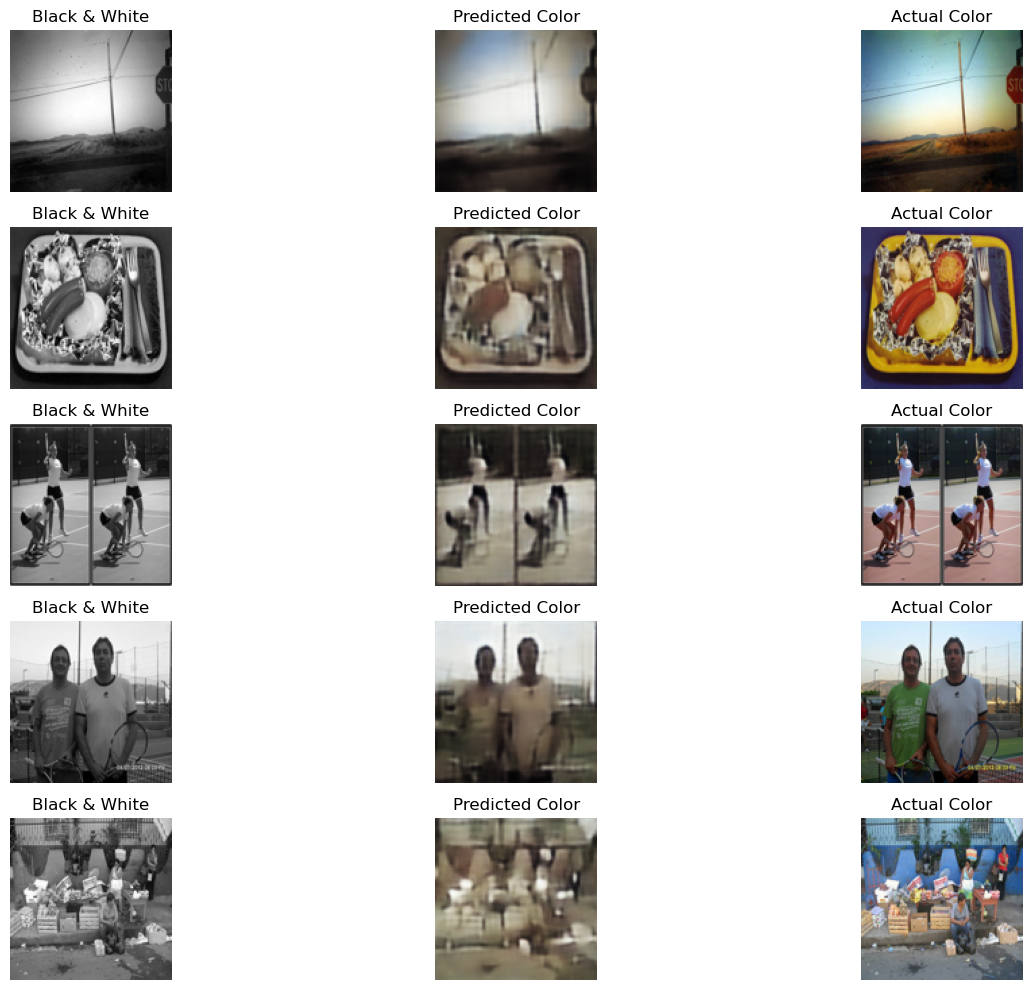

In [32]:
def display_colorization_results(model, x_test, y_test, num_images=5):
    #Generate predictions
    y_pred = model.predict(x_test)

    
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        # Displaying black-and-white test image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x_test[i].squeeze(), cmap='gray')  
        plt.title("Black & White")
        plt.axis('off')

        # Displaying predicted color image
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_pred[i])
        plt.title("Predicted Color")
        plt.axis('off')

        # Displaying actual color image
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(y_test[i])
        plt.title("Actual Color")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# displaying the results
display_colorization_results(autoencoder, x_test, y_test, num_images=5)